<a href="https://colab.research.google.com/github/ndtuan10/Image-Processing-And-Applications_CS406.M11.KHCL/blob/main/BaiTap/Image_Classification/BaiTap7%3A%20Image%20Classification%20using%20MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ngô Đức Tuấn**

MSSV: 18520186

##**Bài tập 7: Phân lớp ảnh (Image Classification)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import các thư viện cần dùng
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print('''
  Phiên bản của các thư viện :
    + Tensorflow : {0}
    + keras : {1}
    + numpy : {2}
    + pandas : {3}
'''.format(tf.__version__, keras.__version__, np.__version__, pd.__version__))


  Phiên bản của các thư viện :
    + Tensorflow : 2.6.0
    + keras : 2.6.0
    + numpy : 1.19.5
    + pandas : 1.1.5



# **Xử lí dataset**

In [3]:
Path_dir = '/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/'
path_train = Path_dir + 'train/'
path_test = Path_dir + 'test/'
path_valid = Path_dir + 'val/'

In [4]:
classNames = os.listdir(path_test)
print(classNames)

['dog', 'cat', 'pan']


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [6]:
def loadData(path):
  A, B = [], []
  for folder_name in classNames:
    folder_path = os.path.join(Path_dir, path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        print(fpath)
        img = image.load_img(fpath, target_size=(224,224))
        img_data = image.img_to_array(img)
        A.append(img_data)
        B.append(folder_name)

  # Preprocessing
  A = np.asarray(A)
  B = np.asarray(B)
  print('Loading completed. ')
  return A,B

In [7]:
# load tập train, test, validation
A_train, B_train = loadData(path_train)
A_test, B_test = loadData(path_test)
A_valid, B_valid = loadData(path_valid)

/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.0.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.1.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.10.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.11.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.12.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.13.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.14.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.15.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.16.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.17.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/Dataset/dogscatspans/train/dog/dog.18.jpg
/content/drive/MyDrive/CS406.M11.KHCL/Baitap/

In [8]:
# Khai phá dữ liệu 
print('A_train: {}, B_train: {}, A_valid: {}, B_valid: {}, A_test: {}, B_test: {}'.format(A_train.shape, B_train.shape, A_valid.shape, B_valid.shape, A_test.shape, B_test.shape))

A_train: (63, 224, 224, 3), B_train: (63,), A_valid: (29, 224, 224, 3), B_valid: (29,), A_test: (42, 224, 224, 3), B_test: (42,)


In [9]:
result = {
    'Data':["A_train", "B_train", "A_valid", "B_valid", "A_test", "B_test"],
    'Shape': [A_train.shape, B_train.shape, A_valid.shape, B_valid.shape, A_test.shape, B_test.shape]
}
pd.DataFrame(result)

,Data,Shape
0,A_train,"(63, 224, 224, 3)"
1,B_train,"(63,)"
2,A_valid,"(29, 224, 224, 3)"
3,B_valid,"(29,)"
4,A_test,"(42, 224, 224, 3)"
5,B_test,"(42,)"


# **Tiền xử lý dữ liệu**

In [10]:
# One hot encoding
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
B_train = lb.fit_transform(B_train)
B_valid = lb.fit_transform(B_valid)

In [11]:
A_train = A_train/255.0
A_valid = A_valid/255.0
A_test = A_test/255.0

# **Huấn luyện mô hình mạng MobileNetV2**

### **1. Thiết kế kiến trúc cho mạng**

In [12]:
# Xây dựng kiến trúc mạng
model = Sequential()

mobileV2 = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False, weights='imagenet')
mobileV2.trainable = False

model.add(mobileV2)
model.add(GlobalAveragePooling2D())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(len(classNames)))
model.add(Activation('softmax'))

# in ra kiến trúc của mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0

### **2. Biên dịch mô hình**
Trước khi mô hình có thể được huấn luyện, chúng ta cần thêm các hàm toán học giúp cho việc đánh giá hay làm mô hình đi " đúng hướng ". Các chỉnh sửa này được thêm vào trong bước *biên dịch* của mô hình:

* *Hàm mất mát* — dùng để tính toán "độ sai sót" của mô hình trong quá trình huấn luyện và dự đoán. Chúng ta cần phải làm cho nghiệm của hàm này nhỏ nhất để kiểm soát mô hình đi đúng hướng. (mất mát càng ít, chính xác càng cao). *Hàm mất mát* hay *loss function* được sử dụng là `crossentropy`.
* *Hàm tối ưu* — Đây là "công cụ" để làm hàm mất mát có nghiệm nhỏ nhất, qua việc cập nhật và chỉnh sửa các tham số có trong hàm mất mát. *Hàm tối ưu* hay *optimizier function* được sử dụng là `Adam`.
* *Thang đo* — dùng để đo đạc độ chính xác qua mỗi quá trình huấn luyện và kiểm tra. Chúng ta sẽ sử dụng phép đo `accuracy`, nhằm nắm được tỉ lệ ảnh được phân loại chính xác.

In [13]:
# Biên dịch mô hình
# tăng cường dữ liệu
aug = ImageDataGenerator(rotation_range=0.18,zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

learning_rate = 0.01
epochs = 5
batch_size = 16
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

## **Không tăng cường dữ liệu (Without Augmentation Dataset)**

### **3. Train mô hình**

In [14]:
# đưa dữ liệu vào và huấn luyện
print('Start training')
import time
start=time.time()
H = model.fit(A_train,B_train,batch_size=batch_size, validation_data=(A_valid,B_valid), steps_per_epoch=A_train.shape[0]//batch_size, epochs=epochs, verbose=1)
stop = time.time()
mobilenetV2_time = {stop - start}
print(f"Training time: {mobilenetV2_time}s")

Start training
Epoch 1/5
3/3 [==============================] - 6s 1s/step - loss: 1.4476 - accuracy: 0.6042 - val_loss: 2.0307 - val_accuracy: 0.6897
Epoch 2/5
3/3 [==============================] - 2s 844ms/step - loss: 0.0439 - accuracy: 0.9787 - val_loss: 5.7300 - val_accuracy: 0.5862
Epoch 3/5
3/3 [==============================] - 2s 812ms/step - loss: 0.0879 - accuracy: 0.9787 - val_loss: 5.1656 - val_accuracy: 0.5862
Epoch 4/5
3/3 [==============================] - 2s 822ms/step - loss: 0.1297 - accuracy: 0.9149 - val_loss: 6.4791 - val_accuracy: 0.5862
Epoch 5/5
3/3 [==============================] - 2s 823ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 7.6147 - val_accuracy: 0.5862
Training time: {23.509002685546875}s


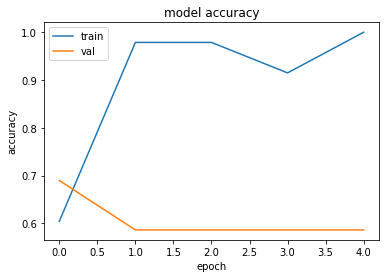

In [15]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

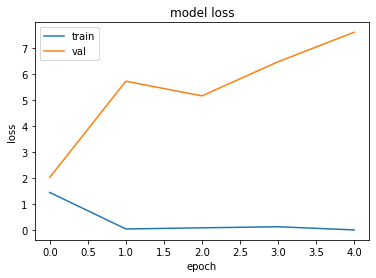

In [16]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **4. Đánh giá mô hình**

In [17]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [18]:
# Hàm vẽ confusion matrix
def CM_plot(M):
    X = [i/sum(i) for i in M]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(X, cmap='Blues', square = True, annot=True, ax=ax)
# Hàm vẽ tương quan predict và recall theo thresholds
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, axlim):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-axlim, axlim, -0.05, 1.05])

In [19]:
# đưa ra dự đoán ảnh
from sklearn.metrics import confusion_matrix, classification_report

label_test = lb.fit_transform(B_test)

B_pred = model.predict(A_test)
print(B_pred.shape)

B_pred = np.argmax(B_pred, axis = 1)
label_test = np.argmax(label_test, axis = 1)

B_pred = B_pred.astype('str')
label_test = label_test.astype('str')

for i in range(B_pred.shape[0]):
  B_pred[i] = classNames[int(B_pred[i])]
  label_test[i] = classNames[int(label_test[i])]

print('Confusion Matrix')
confusion_matrix(label_test, B_pred)

(42, 3)
Confusion Matrix


array([[ 1, 10,  1],
       [ 0, 20,  0],
       [ 0,  3,  7]])

In [20]:
print('Classification Report')
print(classification_report(label_test, B_pred, target_names=classNames))

Classification Report
              precision    recall  f1-score   support

         dog       1.00      0.08      0.15        12
         cat       0.61      1.00      0.75        20
         pan       0.88      0.70      0.78        10

    accuracy                           0.67        42
   macro avg       0.83      0.59      0.56        42
weighted avg       0.78      0.67      0.59        42



In [21]:
accuracy_score_MobileNetV2 = accuracy_score(label_test, B_pred)

print(f'Accuracy score MobileNetV2: {np.multiply(metrics.accuracy_score(label_test, B_pred),100)} %')

Accuracy score MobileNetV2: 66.66666666666666 %


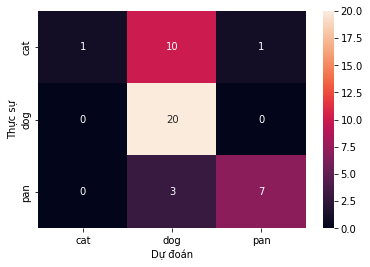

In [22]:
#Xem ma trận nhầm lẫn
cm_matrix = pd.crosstab(label_test, B_pred, rownames=["Thực sự"], colnames=["Dự đoán"])
sns.heatmap(cm_matrix, annot=True, fmt="d")

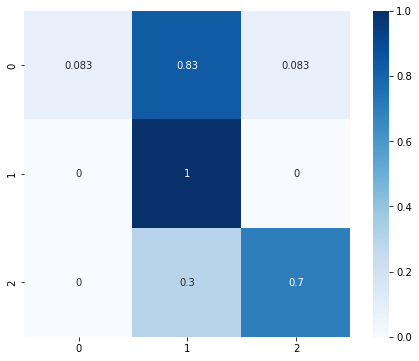

In [23]:
#Chuẩn hóa ma trận
CM_plot(confusion_matrix(label_test, B_pred))

## **Có tăng cường dữ liệu (With Augmentation Dataset)**

### **3. Train mô hình**

In [24]:
# đưa dữ liệu vào và huấn luyện
print('Start training')
import time
start=time.time()
H_aug = model.fit(aug.flow(A_train,B_train,batch_size=batch_size), validation_data=(A_valid,B_valid), steps_per_epoch=A_train.shape[0]//batch_size, epochs=epochs, verbose=1)
stop = time.time()
mobilenetV2_time_aug = {stop - start}
print(f"Training time: {mobilenetV2_time_aug}s")

Start training
Epoch 1/5
3/3 [==============================] - 4s 1s/step - loss: 0.0324 - accuracy: 0.9787 - val_loss: 7.3413 - val_accuracy: 0.5862
Epoch 2/5
3/3 [==============================] - 3s 979ms/step - loss: 0.1663 - accuracy: 0.9362 - val_loss: 3.5378 - val_accuracy: 0.6897
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.4188 - val_accuracy: 0.8966
Epoch 4/5
3/3 [==============================] - 3s 962ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3881 - val_accuracy: 0.8966
Epoch 5/5
3/3 [==============================] - 3s 967ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5864 - val_accuracy: 0.8966
Training time: {22.548131704330444}s


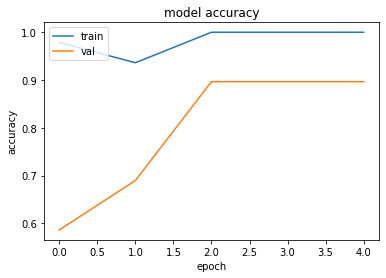

In [25]:
plt.plot(H_aug.history['accuracy'])
plt.plot(H_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

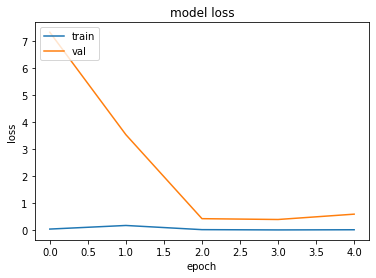

In [26]:
plt.plot(H_aug.history['loss'])
plt.plot(H_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **4. Đánh giá mô hình**

In [27]:
# đưa ra dự đoán ảnh
label_test = lb.fit_transform(B_test)

B_pred = model.predict(A_test)
print(B_pred.shape)

B_pred = np.argmax(B_pred, axis = 1)
label_test = np.argmax(label_test, axis = 1)

B_pred = B_pred.astype('str')
label_test = label_test.astype('str')

for i in range(B_pred.shape[0]):
  B_pred[i] = classNames[int(B_pred[i])]
  label_test[i] = classNames[int(label_test[i])]

print('Confusion Matrix')
confusion_matrix(label_test, B_pred)

(42, 3)
Confusion Matrix


array([[11,  0,  1],
       [ 0, 20,  0],
       [ 0,  0, 10]])

In [28]:
print('Classification Report')
print(classification_report(label_test, B_pred, target_names=classNames))

Classification Report
              precision    recall  f1-score   support

         dog       1.00      0.92      0.96        12
         cat       1.00      1.00      1.00        20
         pan       0.91      1.00      0.95        10

    accuracy                           0.98        42
   macro avg       0.97      0.97      0.97        42
weighted avg       0.98      0.98      0.98        42



In [29]:
accuracy_score_MobileNetV2_aug = accuracy_score(label_test, B_pred)
print(f'Do chinh xac (Accuracy) MobileNetV2 augmentation: {np.multiply(metrics.accuracy_score(label_test, B_pred),100)} %')

Do chinh xac (Accuracy) MobileNetV2 augmentation: 97.61904761904762 %


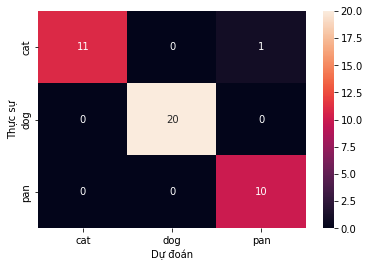

In [30]:
#Xem ma trận nhầm lẫn
cm_matrix = pd.crosstab(label_test, B_pred, rownames=["Thực sự"], colnames=["Dự đoán"])
sns.heatmap(cm_matrix, annot=True, fmt="d")

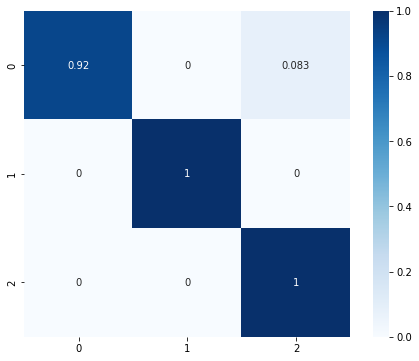

In [31]:
#Chuẩn hóa ma trận
CM_plot(confusion_matrix(label_test, B_pred))

## **So sánh kết quả**

In [36]:
results_dict={'Phuong phap phan lop':['MobileNetV2 (without aug)', 'MobileNetV2 (with aug)'],
              'Accuracy':['66.66%', '97.62%'],
              'Time':['23.51s', '22.55s'],}
pd.DataFrame(results_dict)

,Phuong phap phan lop,Accuracy,Time
0,MobileNetV2 (without aug),66.66%,23.51s
1,MobileNetV2 (with aug),97.62%,22.55s


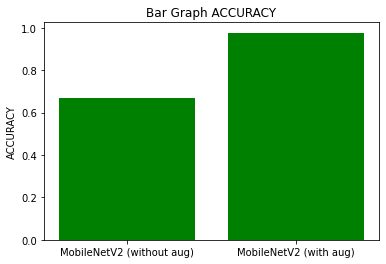

In [32]:
#in biểu đồ
BarGraph=['MobileNetV2 (without aug)','MobileNetV2 (with aug)']
accuracy=[accuracy_score_MobileNetV2,accuracy_score_MobileNetV2_aug]
plt.bar(BarGraph,accuracy,color='green')
plt.title('Bar Graph ACCURACY')
plt.xlabel('')
plt.ylabel('ACCURACY')
plt.show()

In [34]:
print('Thời gian huấn luyện các mô hình:')
print('MobileNetV2 (without aug) : \n','time:', mobilenetV2_time)
print('======================================================')
print('MobileNetV2 (with aug) : \n','time:', mobilenetV2_time_aug)
print('======================================================')

print('****======================================================****')

print('Độ chính xác các mô hình:')
print('MobileNetV2 (without aug) : \n','accuracy:', accuracy_score_MobileNetV2)
print('======================================================')
print('MobileNetV2 (with aug) : \n','accuracy:', accuracy_score_MobileNetV2_aug)
print('======================================================')

Thời gian huấn luyện các mô hình:
MobileNetV2 (without aug) : 
 time: {23.509002685546875}
MobileNetV2 (with aug) : 
 time: {22.548131704330444}
****======================================================****
Độ chính xác các mô hình:
MobileNetV2 (without aug) : 
 accuracy: 0.6666666666666666
MobileNetV2 (with aug) : 
 accuracy: 0.9761904761904762
